In [2]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('ggplot')

In [3]:
def read_data(dir_path, file_prefix, r):
    file_path = os.path.join(dir_path, '{}_{}.csv'.format(file_prefix, r))
    with open(file_path, 'r') as f:
        data = np.fromstring(f.read().strip(), sep=',').astype('int32')
    
    return data

## Market's econolgy

In [18]:
# Parameters
s = 2
p = 64
eps = -100
rhok = 0
rhos = 0
n_minority_agents = 200
n_speculator_agents = 0
n_producer_agents_array = np.linspace(0, 200, 11).astype('int32')
n_iters = 50000
n_runs = 1

start_timestep = 30000

for n_producer_agents in n_producer_agents_array:
    # Read data
    dir_path = '../data/simulation/s{}_p{}_eps{:.2f}_rhok{:.2f}_rhos{:.2f}_nmins{}_npros{}_nspes{}_niters{}_nruns{}/'.format(
        s, p, eps, rhok, rhos, n_minority_agents, n_producer_agents, n_speculator_agents, n_iters, n_runs)
    
    excess_demand_history = read_data(dir_path, 'excess_demand_history', 0)
    excess_demand_history = excess_demand_history[start_timestep:]

## Volatility clustering

[]

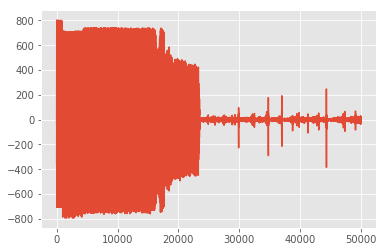

In [38]:
# Parameters
s = 2
p = 16
eps = 0.01
rhok = 0
rhos = 0
n_minority_agents = 0
n_speculator_agents = 1001
n_producer_agents = 1200
n_iters = 50000
n_runs = 5

start_timestep = 30000

# Read data
dir_path = '../data/simulation/s{}_p{}_eps{:.2f}_rhok{:.2f}_rhos{:.2f}_nmins{}_npros{}_nspes{}_niters{}_nruns{}/'.format(
    s, p, eps, rhok, rhos, n_minority_agents, n_producer_agents, n_speculator_agents, n_iters, n_runs)

excess_demand_history = read_data(dir_path, 'excess_demand_history', 0)
# excess_demand_history = excess_demand_history[start_timestep:]

plt.plot(excess_demand_history)

plt.plot()

## Autocorrelation of the absolute returns

In [39]:
def compute_autocorrelation(x, tau):
    x_tau = x[tau:]
    
    x1 = np.abs(x_tau)
    x2 = np.abs(x[:-tau])
    
    corr, _ = stats.pearsonr(x1, x2)
    return corr

(0.0001, 1)

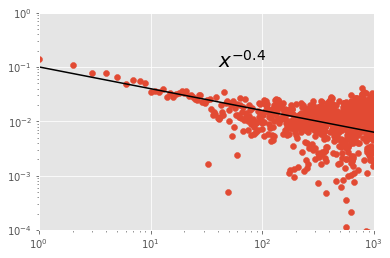

In [40]:
# Parameters
s = 2
p = 16
eps = 0.01
n_minority_agents = 0
n_speculator_agents = 501
n_producer_agents = 1000
n_iters = 50000
n_runs = 5

start_timestep = 30000

# Read data
dir_path = '../data/simulation/s{}_p{}_eps{:.2f}_rhok{:.2f}_rhos{:.2f}_nmins{}_npros{}_nspes{}_niters{}_nruns{}/'.format(
    s, p, eps, rhok, rhos, n_minority_agents, n_producer_agents, n_speculator_agents, n_iters, n_runs)

excess_demand_history = read_data(dir_path, 'excess_demand_history', 0)
excess_demand_history = excess_demand_history[start_timestep:]

taus = np.arange(1, 1001)
corrs = np.array([compute_autocorrelation(excess_demand_history, tau) for tau in taus])

plt.scatter(taus, corrs)

ws = np.float_power(taus, -0.4) * 0.1

plt.text(10 * 4, 1e-1, r'$x^{-0.4}$', fontsize=20)

plt.plot(taus, ws, c='black')

plt.xscale('log')
plt.yscale('log')

x_max, x_min = 1e+3, 1
y_max, y_min = 1, 1e-4

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

## Cumulative distribution of price returns

In [41]:
def compute_cumulative_distribution(counts):
    sum_counts = np.sum(counts)
    ys = np.array([np.sum(counts[i:]) / sum_counts for i in range(len(counts))])
    return ys

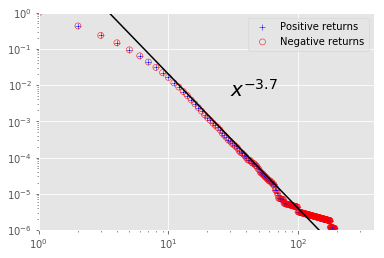

In [42]:
# Parameters
s = 2
p = 16
eps = 0.01
n_minority_agents = 0
n_speculator_agents = 1001
n_producer_agents = 1200
n_iters = 50000
n_runs = 5

start_timestep = 30000

# Read data
dir_path = '../data/simulation/s{}_p{}_eps{:.2f}_rhok{:.2f}_rhos{:.2f}_nmins{}_npros{}_nspes{}_niters{}_nruns{}/'.format(
    s, p, eps, rhok, rhos, n_minority_agents, n_producer_agents, n_speculator_agents, n_iters, n_runs)

excess_demand_history = read_data(dir_path, 'excess_demand_history', 0)
excess_demand_history = excess_demand_history[start_timestep:]

x_max = np.max(np.abs(excess_demand_history))
x_min = 1

return_positive = np.sort(np.array([elem for elem in excess_demand_history if elem > 0]))
return_negative = np.sort(np.array([- elem for elem in excess_demand_history if elem < 0]))

xs = np.linspace(x_min, x_max, x_max - x_min + 1, dtype='int32')
counts_positive, _ = np.histogram(return_positive, bins=xs.tolist() + [x_max + 1])
counts_negative, _ = np.histogram(return_positive, bins=xs.tolist() + [x_max + 1])

ys_positive = compute_cumulative_distribution(counts_positive)
ys_negative = compute_cumulative_distribution(counts_negative)

# Divide by return
ys_positive /= xs
ys_negative /= xs

y_max = 1
y_min = 1e-6

plt.scatter(xs, ys_positive, marker='+', facecolors='blue', edgecolors='none', label='Positive returns', linewidth=.5)
plt.scatter(xs, ys_negative, marker='o', facecolors='none', edgecolors='red', label='Negative returns', linewidth=.5)

# Powerlaw fitting
ws = np.float_power(xs, -3.7) * 100
plt.plot(xs, ws, c='black')

plt.text(10 * 3, 1e-2 * 0.5, r'$x^{-3.7}$', fontsize=20)

plt.xscale('log')
plt.yscale('log')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.legend()

plt.show()

## Reproducibility of stylized facts

- Volatility clustering
- Power law distribution of price returns
- Slow decay of autocorrelation of absolute price returns

- vcのylim, start_timestep修正

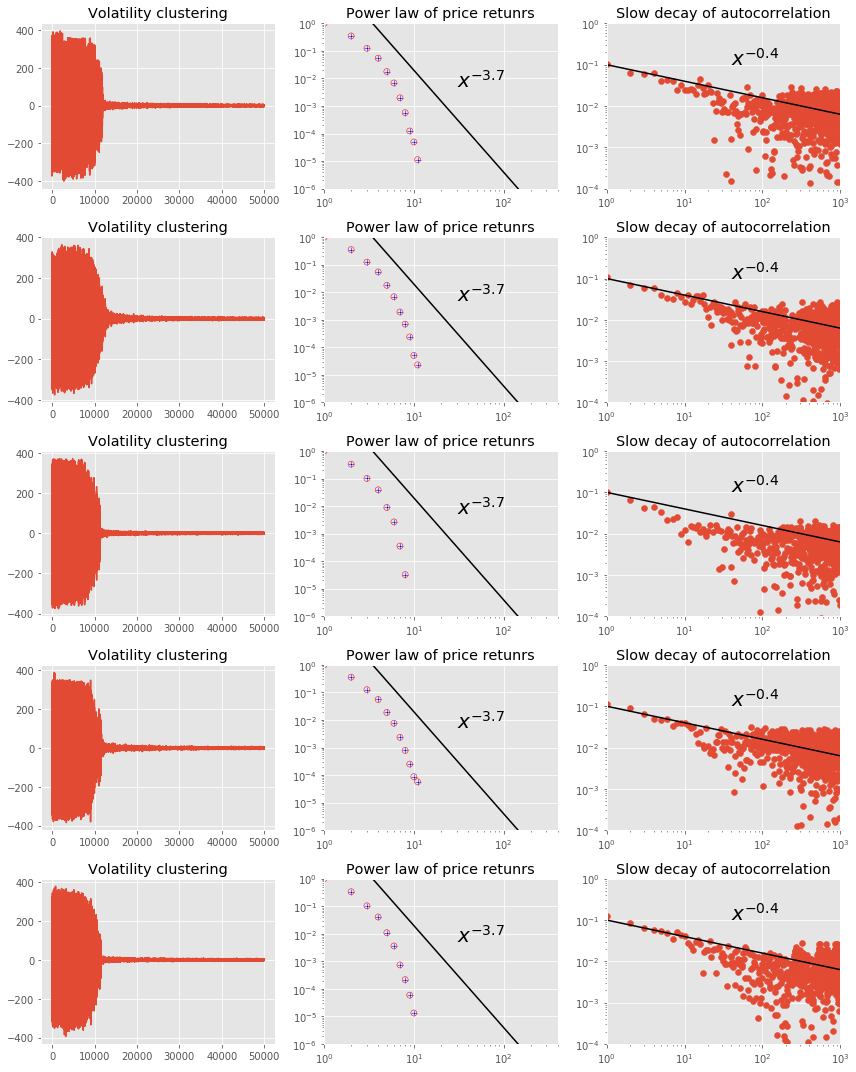

In [45]:
# Parameters
s = 2
p = 16
eps = 0.01
n_minority_agents = 0
n_speculator_agents = 501
n_producer_agents = 1001
n_iters = 50000
n_runs = 5

taus = np.arange(1, 1001)

start_timestep = 30000

dir_path = '../data/simulation/s{}_p{}_eps{:.2f}_rhok{:.2f}_rhos{:.2f}_nmins{}_npros{}_nspes{}_niters{}_nruns{}/'.format(
    s, p, eps, rhok, rhos, n_minority_agents, n_producer_agents, n_speculator_agents, n_iters, n_runs)

fig = plt.figure(figsize=(12, 15))

for r in range(n_runs):
    # Read data
    excess_demand_history = read_data(dir_path, 'excess_demand_history', r)
    excess_demand_history_with_warmup = excess_demand_history[start_timestep:]
    
    # Volatility clustering
    ax1 = fig.add_subplot(n_runs, 3, r * 3 + 1)
    ax1.plot(excess_demand_history)
    ax1.set_title('Volatility clustering')
    
    # Power law distribution of price returns
    ax2 = fig.add_subplot(n_runs, 3, r * 3 + 2)
    return_positive = np.sort(np.array([elem for elem in excess_demand_history_with_warmup if elem > 0]))
    return_negative = np.sort(np.array([- elem for elem in excess_demand_history_with_warmup if elem < 0]))

    xs = np.linspace(1, 400, 400 - 1 + 1, dtype='int32')
    counts_positive, _ = np.histogram(return_positive, bins=xs.tolist() + [400 + 1])
    counts_negative, _ = np.histogram(return_positive, bins=xs.tolist() + [400 + 1])

    ys_positive = compute_cumulative_distribution(counts_positive)
    ys_negative = compute_cumulative_distribution(counts_negative)

    # Divide by return
    ys_positive /= xs
    ys_negative /= xs

    plt.scatter(xs, ys_positive, marker='+', facecolors='blue', edgecolors='none', label='Positive returns', linewidth=.5)
    plt.scatter(xs, ys_negative, marker='o', facecolors='none', edgecolors='red', label='Negative returns', linewidth=.5)

    # Powerlaw fitting
    ws = np.float_power(xs, -3.7) * 100
    plt.plot(xs, ws, c='black')

    plt.text(10 * 3, 1e-2 * 0.5, r'$x^{-3.7}$', fontsize=20)
    
    ax2.set_title('Power law of price retunrs')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim(1, 400)
    ax2.set_ylim(1e-6, 1)
    
    # Slow decay of absolute price returns
    ax3 = fig.add_subplot(n_runs, 3, r * 3 + 3)
    excess_demand_history_with_warmup = excess_demand_history[start_timestep:]
    corrs = np.array([compute_autocorrelation(excess_demand_history_with_warmup, tau) for tau in taus])
    ax3.scatter(taus, corrs)

    ax3.set_title('Slow decay of autocorrelation')
    ax3.text(10 * 4, 1e-1, r'$x^{-0.4}$', fontsize=20)
    ws = np.float_power(taus, -0.4) * 0.1
    ax3.plot(taus, ws, c='black')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_xlim(1, 1e+3)
    ax3.set_ylim(1e-4, 1)

plt.tight_layout()

plt.show()

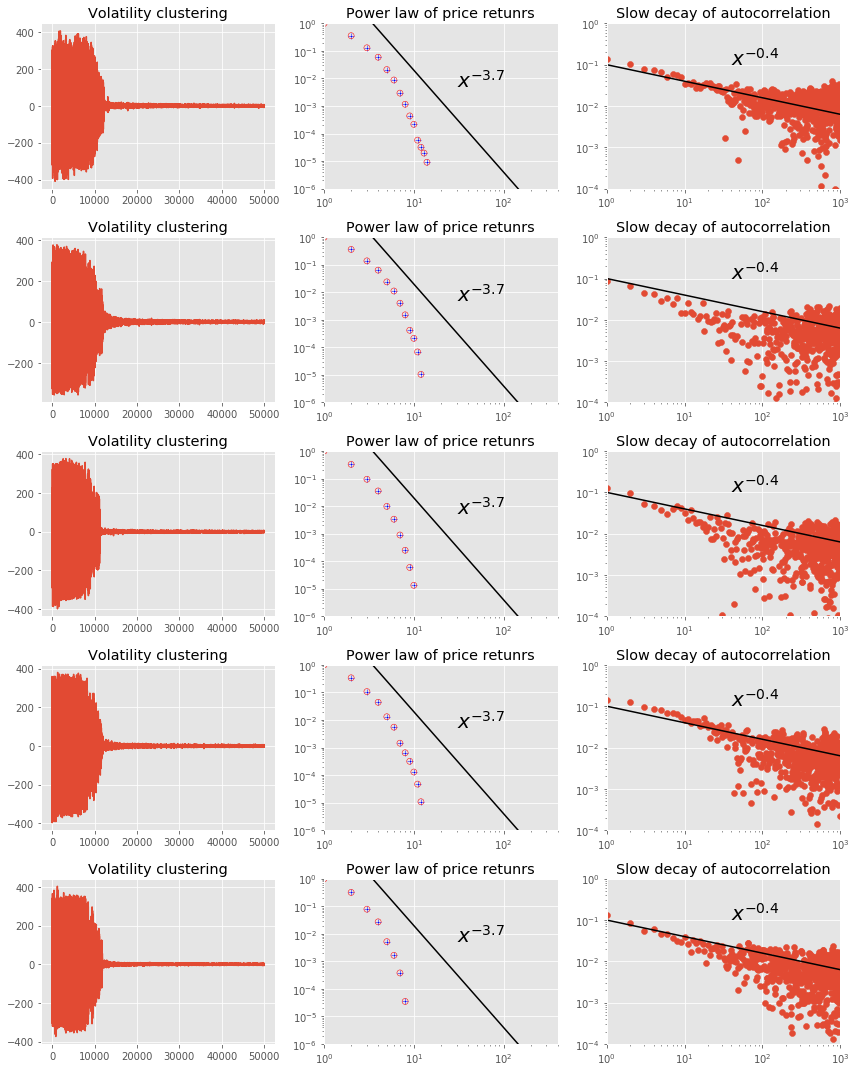

In [46]:
# Parameters
s = 2
p = 16
eps = 0.01
n_minority_agents = 0
n_speculator_agents = 501
n_producer_agents = 1000
n_iters = 50000
n_runs = 5

taus = np.arange(1, 1001)

start_timestep = 30000

dir_path = '../data/simulation/s{}_p{}_eps{:.2f}_rhok{:.2f}_rhos{:.2f}_nmins{}_npros{}_nspes{}_niters{}_nruns{}/'.format(
    s, p, eps, rhok, rhos, n_minority_agents, n_producer_agents, n_speculator_agents, n_iters, n_runs)

fig = plt.figure(figsize=(12, 15))

for r in range(n_runs):
    # Read data
    excess_demand_history = read_data(dir_path, 'excess_demand_history', r)
    excess_demand_history_with_warmup = excess_demand_history[start_timestep:]
    
    # Volatility clustering
    ax1 = fig.add_subplot(n_runs, 3, r * 3 + 1)
    ax1.plot(excess_demand_history)
    ax1.set_title('Volatility clustering')
    
    # Power law distribution of price returns
    ax2 = fig.add_subplot(n_runs, 3, r * 3 + 2)
    return_positive = np.sort(np.array([elem for elem in excess_demand_history_with_warmup if elem > 0]))
    return_negative = np.sort(np.array([- elem for elem in excess_demand_history_with_warmup if elem < 0]))

    xs = np.linspace(1, 400, 400 - 1 + 1, dtype='int32')
    counts_positive, _ = np.histogram(return_positive, bins=xs.tolist() + [400 + 1])
    counts_negative, _ = np.histogram(return_positive, bins=xs.tolist() + [400 + 1])

    ys_positive = compute_cumulative_distribution(counts_positive)
    ys_negative = compute_cumulative_distribution(counts_negative)

    # Divide by return
    ys_positive /= xs
    ys_negative /= xs

    plt.scatter(xs, ys_positive, marker='+', facecolors='blue', edgecolors='none', label='Positive returns', linewidth=.5)
    plt.scatter(xs, ys_negative, marker='o', facecolors='none', edgecolors='red', label='Negative returns', linewidth=.5)

    # Powerlaw fitting
    ws = np.float_power(xs, -3.7) * 100
    plt.plot(xs, ws, c='black')

    plt.text(10 * 3, 1e-2 * 0.5, r'$x^{-3.7}$', fontsize=20)
    
    ax2.set_title('Power law of price retunrs')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim(1, 400)
    ax2.set_ylim(1e-6, 1)
    
    # Slow decay of absolute price returns
    ax3 = fig.add_subplot(n_runs, 3, r * 3 + 3)
    excess_demand_history_with_warmup = excess_demand_history[start_timestep:]
    corrs = np.array([compute_autocorrelation(excess_demand_history_with_warmup, tau) for tau in taus])
    ax3.scatter(taus, corrs)

    ax3.set_title('Slow decay of autocorrelation')
    ax3.text(10 * 4, 1e-1, r'$x^{-0.4}$', fontsize=20)
    ws = np.float_power(taus, -0.4) * 0.1
    ax3.plot(taus, ws, c='black')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_xlim(1, 1e+3)
    ax3.set_ylim(1e-4, 1)

plt.tight_layout()

plt.show()

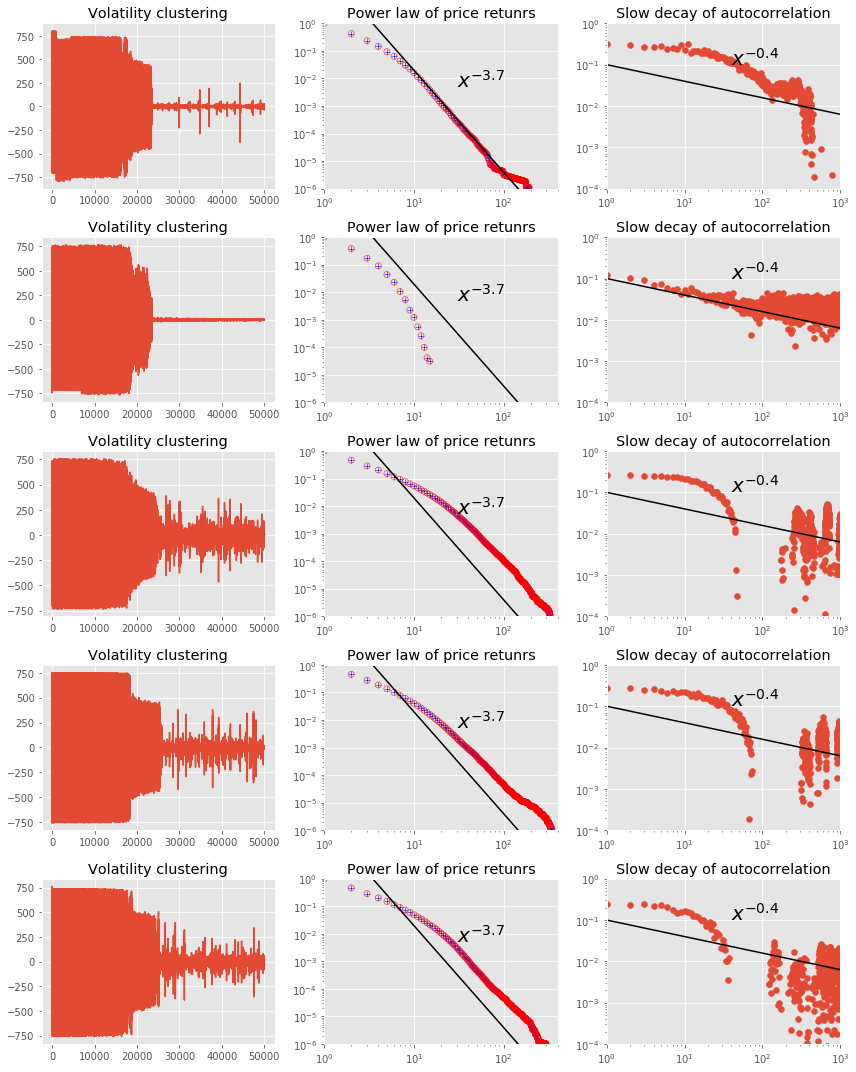

In [47]:
# Parameters
s = 2
p = 16
eps = 0.01
n_minority_agents = 0
n_speculator_agents = 1001
n_producer_agents = 1200
n_iters = 50000
n_runs = 5

taus = np.arange(1, 1001)

start_timestep = 30000

dir_path = '../data/simulation/s{}_p{}_eps{:.2f}_rhok{:.2f}_rhos{:.2f}_nmins{}_npros{}_nspes{}_niters{}_nruns{}/'.format(
    s, p, eps, rhok, rhos, n_minority_agents, n_producer_agents, n_speculator_agents, n_iters, n_runs)

fig = plt.figure(figsize=(12, 15))

for r in range(n_runs):
    # Read data
    excess_demand_history = read_data(dir_path, 'excess_demand_history', r)
    excess_demand_history_with_warmup = excess_demand_history[start_timestep:]
    
    # Volatility clustering
    ax1 = fig.add_subplot(n_runs, 3, r * 3 + 1)
    ax1.plot(excess_demand_history)
    ax1.set_title('Volatility clustering')
    
    # Power law distribution of price returns
    ax2 = fig.add_subplot(n_runs, 3, r * 3 + 2)
    return_positive = np.sort(np.array([elem for elem in excess_demand_history_with_warmup if elem > 0]))
    return_negative = np.sort(np.array([- elem for elem in excess_demand_history_with_warmup if elem < 0]))

    xs = np.linspace(1, 400, 400 - 1 + 1, dtype='int32')
    counts_positive, _ = np.histogram(return_positive, bins=xs.tolist() + [400 + 1])
    counts_negative, _ = np.histogram(return_positive, bins=xs.tolist() + [400 + 1])

    ys_positive = compute_cumulative_distribution(counts_positive)
    ys_negative = compute_cumulative_distribution(counts_negative)

    # Divide by return
    ys_positive /= xs
    ys_negative /= xs

    plt.scatter(xs, ys_positive, marker='+', facecolors='blue', edgecolors='none', label='Positive returns', linewidth=.5)
    plt.scatter(xs, ys_negative, marker='o', facecolors='none', edgecolors='red', label='Negative returns', linewidth=.5)

    # Powerlaw fitting
    ws = np.float_power(xs, -3.7) * 100
    plt.plot(xs, ws, c='black')

    plt.text(10 * 3, 1e-2 * 0.5, r'$x^{-3.7}$', fontsize=20)
    
    ax2.set_title('Power law of price retunrs')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim(1, 400)
    ax2.set_ylim(1e-6, 1)
    
    # Slow decay of absolute price returns
    ax3 = fig.add_subplot(n_runs, 3, r * 3 + 3)
    excess_demand_history_with_warmup = excess_demand_history[start_timestep:]
    corrs = np.array([compute_autocorrelation(excess_demand_history_with_warmup, tau) for tau in taus])
    ax3.scatter(taus, corrs)

    ax3.set_title('Slow decay of autocorrelation')
    ax3.text(10 * 4, 1e-1, r'$x^{-0.4}$', fontsize=20)
    ws = np.float_power(taus, -0.4) * 0.1
    ax3.plot(taus, ws, c='black')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_xlim(1, 1e+3)
    ax3.set_ylim(1e-4, 1)

plt.tight_layout()

plt.show()